<a href="https://colab.research.google.com/github/tanish-g/kaggle-competition-MOVIES-GENRE-CLASSIFICATION-/blob/master/2nd_Place_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "guptatanish" # username from the json file
os.environ['KAGGLE_KEY'] = "c8d551bfd1380dcb9dd2fb3c562bfc23" # key from the json file
!kaggle datasets download -d sshukla21/clabscvcomp # api copied from kaggle
!unzip -qq clabscvcomp.zip
!rm -r clabscvcomp.zip


100% 11.0G/11.1G [04:24<00:00, 64.3MB/s]
100% 11.1G/11.1G [04:24<00:00, 44.8MB/s]


In [ ]:
from fastai import *
from fastai.vision import *
from sklearn.metrics import f1_score

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(43)

In [ ]:
train = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/sample_submission.csv')

train.head()

,id,genres
0,71139,Comedy
1,73330,Comedy
2,53693,Documentary
3,121140,Horror
4,45090,Adventure


In [ ]:
sorted(train.genres.unique()) 

['Action',
 'Adventure',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Horror',
 'Romance',
 'Sci-Fi',
 'Thriller']

In [ ]:
train.genres.value_counts(normalize=True) 

Comedy         0.184648
Documentary    0.171221
Drama          0.139154
Horror         0.132541
Thriller       0.097067
Action         0.092257
Romance        0.086379
Crime          0.035473
Adventure      0.034672
Sci-Fi         0.026588
Name: genres, dtype: float64

In [ ]:
sz = 512 ## Image size
bs = 12  ## Batch size
tfms = get_transforms( ## Transformation to apply on Train data
    do_flip=False, ## Horizontal flip
    flip_vert=False, ## Vertical flip
    max_rotate=None, ## Rotation
    max_zoom=1.5, ## Center zoom
    max_lighting=0.75 ## lighting
)

In [ ]:
data = (
    ImageList.from_df(df=train, path='', folder='data/train_data/', cols='id', suffix = '.jpg') ## define data path
    .split_by_rand_pct(valid_pct=0.2) ## validation split
    .label_from_df(cols='genres') ## load labels from
    .transform(tfms, size=sz)
    .databunch(bs=bs, num_workers=6) 
    .normalize(imagenet_stats)
    )

In [ ]:
test_data = ImageList.from_df(test_df, path='data/test_data/', cols='id', suffix = '.jpg')
data.add_test(test_data)

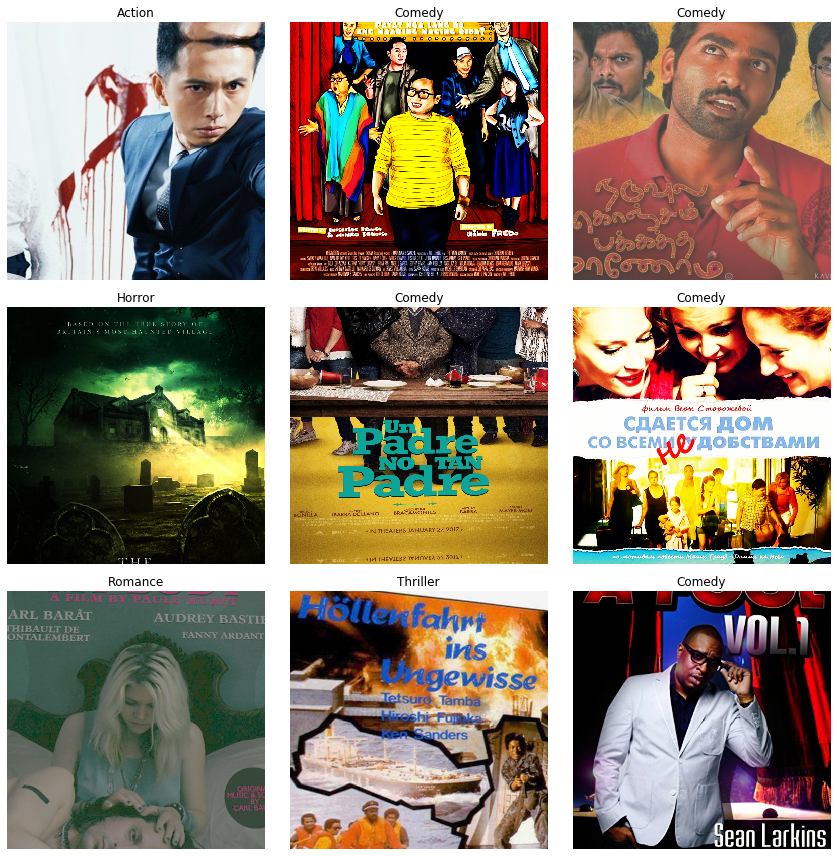

In [ ]:
data.show_batch(3)

In [ ]:
!pip install timm

     |████████████████████████████████| 143kB 3.4MB/s 


In [ ]:
import timm

In [ ]:
def F1(y_pred, y):
    y_pred = y_pred.softmax(dim=1) 
    y_pred = y_pred.argmax(dim=1)
    return torch.tensor(f1_score(y.cpu(), y_pred.cpu(), labels=list(range(10)), average='weighted'),device='cuda:0')

In [ ]:
learn = cnn_learner(
                    data, ## DataBunch
                    timm.models.resnext101_32x4d, ## Resnet50 
                    metrics=[F1, accuracy], ## Matrices
                    callback_fns=ShowGraph ## Allows us to visualize training
)

epoch,train_loss,valid_loss,F1,accuracy,time
0,2.662445,2.133854,0.213990,0.245239,19:37
1,2.313673,2.075030,0.217140,0.262279,20:00
2,2.241049,2.127220,0.203227,0.254594,19:58
3,2.088937,2.057999,0.212563,0.277314,19:58
4,2.099786,2.013819,0.227771,0.276311,19:57


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


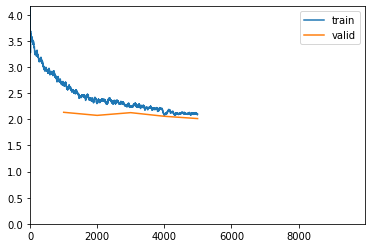

In [ ]:
learn.freeze() 
learn.fit_one_cycle(10)

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(20, max_lr=slice(1e-6, 8e-6))

In [ ]:
preds = learn.get_preds(ds_type=DatasetType.Test) ## get prediction in test data
preds = np.argmax(preds[0].numpy(),axis = 1)
categories = sorted(train.genres.unique().astype('str'))
final_preds = []
for idx in preds:
    final_preds.append(categories[idx])
final_submit = pd.read_csv('data/sample_submission.csv')
final_submit.genres = final_preds
final_submit.head()
final_submit.to_csv('submission.csv',index = False)